In [1]:
import warnings

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import statsmodels.api as sm
import numpy as np

In [2]:
# load data
xl = pd.ExcelFile('input_data.xlsx')

data = {sheet_name: xl.parse(sheet_name) for sheet_name in xl.sheet_names}

res = []

for name in xl.sheet_names:
    mylist = map(list, zip(*data[name].values))
    aux = list(it.chain(*mylist))
    del aux[:24]
    res.append(aux)

res = list(it.chain(*res))

3818.95
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3928      0.029     13.711      0.000       0.337       0.449
ma.L1         -0.9896      0.017    -58.104      0.000      -1.023      -0.956
ar.S.L168     -0.4395      0.020    -22.298      0.000      -0.478      -0.401
sigma2      5239.8803    184.709     28.368      0.000    4877.858    5601.903


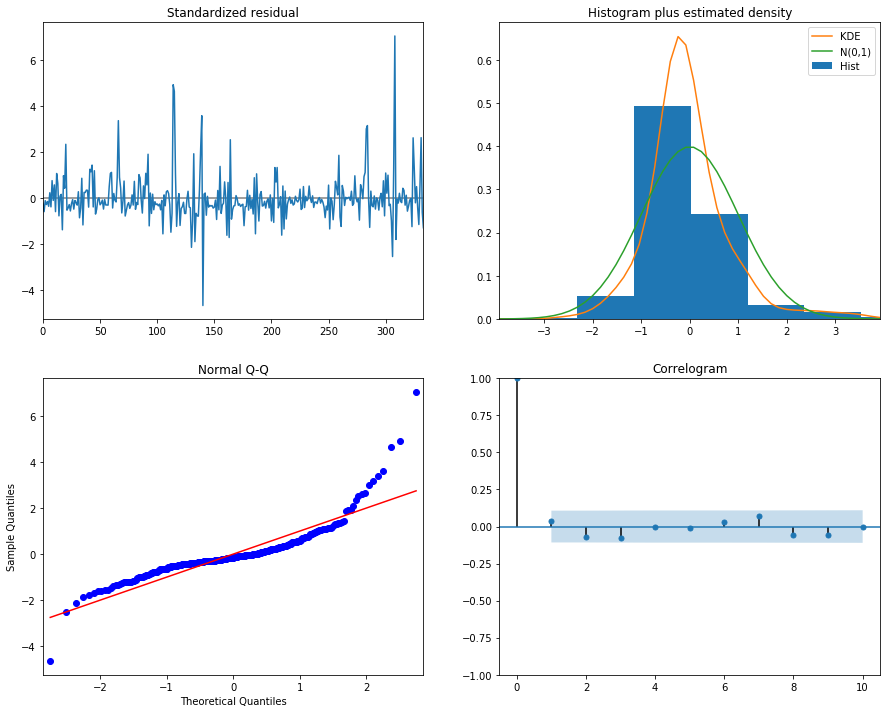

In [3]:
# train Seasonal ARIMA model
mod = sm.tsa.statespace.SARIMAX(res,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 168),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print(round(results.aic,2))
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

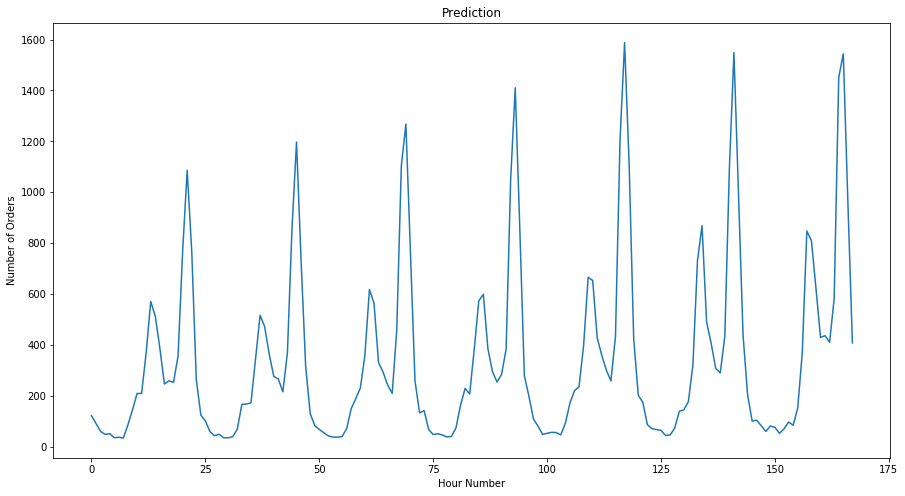

In [6]:
# Get forecast one week ahead in future
pred_uc = results.get_forecast(steps=168)

plt.rcParams['figure.figsize'] = [15, 8]

plt.plot(pred_uc.predicted_mean)
# plt.plot(res[-168:], color='red') # compare with previous week
plt.xlabel('Hour Number')
plt.ylabel('Number of Orders')
plt.title('Prediction')
plt.show()

In [7]:
# save to excel
rows = range(0,24)
cols = ['HOURS', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']

df = pd.DataFrame(columns=cols,
                  index=rows)
df['HOURS'] = rows

pred_uc.predicted_mean = pred_uc.predicted_mean.astype(int)
fc = [pred_uc.predicted_mean[i:i + 24] for i in range(0, len(pred_uc.predicted_mean), 24)]

for i in enumerate(fc):
    df[cols[i[0] + 1]] = i[1]

df.to_excel('results.xlsx', sheet_name='W5', index=False)

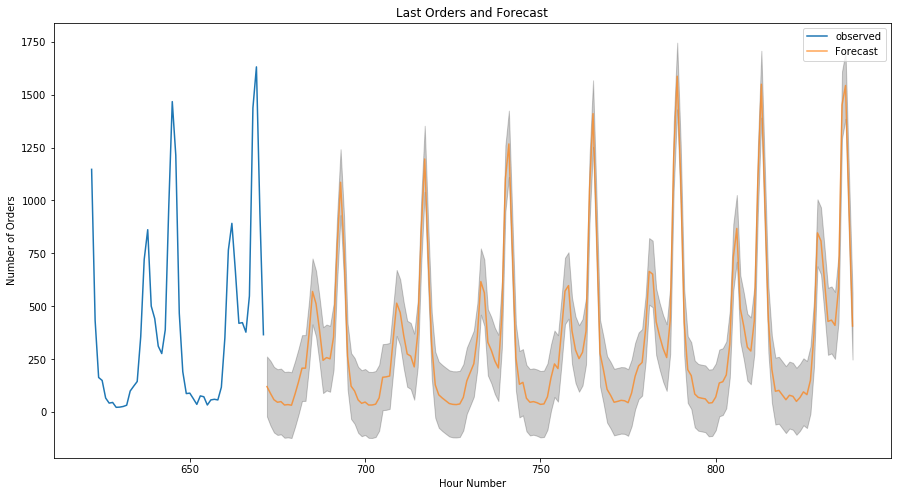

In [10]:
# plot LAST_N_SAMPLES and prediction
LAST_N_SAMPLES = 50

pred_ci = pred_uc.conf_int()

X_obs = range(0, 672)
X_pred = range(672, 840)

plt.plot(X_obs[-LAST_N_SAMPLES:], res[-LAST_N_SAMPLES:], label='observed')
plt.plot(X_pred[:168], pred_uc.predicted_mean[:168], label='Forecast', alpha=.7)

plt.fill_between(X_pred,
                pred_ci[:, 0],
                pred_ci[:, 1], color='k', alpha=.2)

plt.xlabel('Hour Number')
plt.ylabel('Number of Orders')
plt.title('Last Orders and Forecast')
plt.legend()
plt.show()

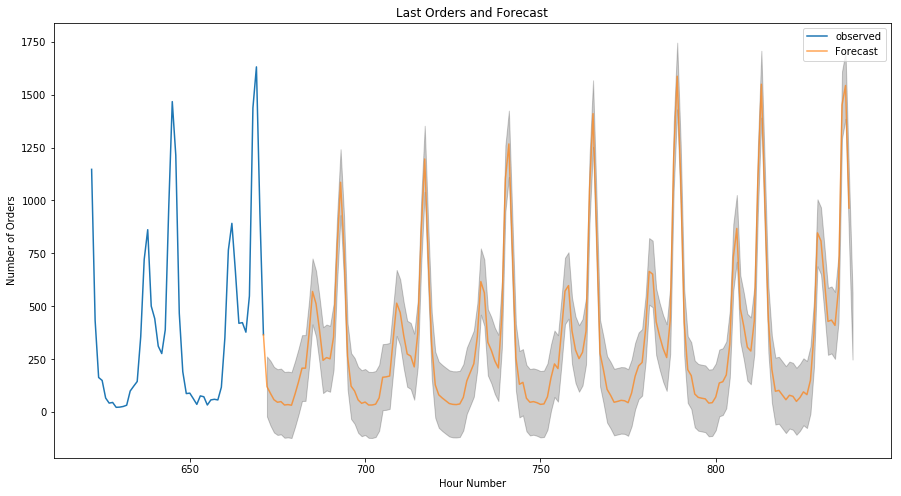

In [11]:
# add last observed value as first predicted one to avoid gap in graph

X_pred = range(671, 840) # predicted range will start one sample before

pred_uc.predicted_mean = np.insert(pred_uc.predicted_mean, 0, res[-1], axis=0) # we insert the value

plt.plot(X_obs[-LAST_N_SAMPLES:], res[-LAST_N_SAMPLES:], label='observed')
plt.plot(X_pred[:168], pred_uc.predicted_mean[:168], label='Forecast', alpha=.7)

plt.fill_between(X_pred[1:], # now we fill confidence interval starting at sample index 1
                pred_ci[:, 0],
                pred_ci[:, 1], color='k', alpha=.2)

plt.xlabel('Hour Number')
plt.ylabel('Number of Orders')
plt.title('Last Orders and Forecast')
plt.legend()
plt.show()